# Dog breed classiication with transfer learning on AWS SageMaker

- **In this notebook we walk through fine-tuning a pretrained image classification moddel to better predict 133 types of dog breeds using dog breed dataset provided by Udacity (https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) while implementing profiling and debugging, then uploading the model to an endpoint and performing infrences.**

<br>

- The pretrained model used is the RESNET50 model from the pytorch libirary (https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html).

- We will use transfer learning to fine tune the model to our use case by adding 2 fully connected nn layers while freezing the model's original convolutional layers.

- We will perform hyperparameter tuning and use the best hyperparameters to fine tune our model.

- we will implement profiling and debugging.

- We will deploy the model to an endpoint and make test infrences.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.session import Session

role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()

print(f"Region : {region}")
print(f"Default s3 bucket : {bucket}")

Region : us-east-1
Default s3 bucket : sagemaker-us-east-1-117886809722


## Dataset

the dataset used in this notebook is the dogImages dataset, it contains images of 133 breeds of dogs split into training, testing and validation sets

In [6]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!cd dogImages
!unzip dogImages.zip   

--2022-11-15 21:44:22--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.240
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  29.8MB/s    in 37s     

2022-11-15 21:45:02 (28.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinsc

In [11]:
prefix ="dogBreedImageData"
print("Starting to upload dogBreedImages")

input_data = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {input_data}")

Starting to upload dogBreedImages
Input path ( S3 file path ): s3://sagemaker-us-east-1-117886809722/dogBreedImageData


## Hyperparameter Tuning

- AdamW optimizer is used for it's better generalization and ease of hyperparameter tuning while improving upon the original adam optimizer by decoupling the weight decay from the learning rate which leads to better generalization and better results in most empirical results... closing the performance gap to "SGD with momentum".

- the following hyperparameters are tuned within the following ranges
    - Learning rate- 0.01x to 100x  
    - eps - 1e-09 to 1e-08
    - Weight decay - 0.1x to 10x
    - Batch size - [ 64, 128 ]

In [12]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# We wil be using AdamW as an optimizer because it generalizes better due to decoupling weight decay calculation from learning rate
# So we will tune lhe learning rate and weight decay to take advantage of this as well as the epochs and batch size
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}


objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [13]:
#TODO: Create estimators for your HPs
from  sagemaker.pytorch import PyTorch


estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py36",
    framework_version = "1.8"
)


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [16]:
# TODO: Fit your HP Tuner
tuner.fit({"training": input_data }, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................................................................................................................................................................................................................................................................................................!


In [17]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-11-15 23:15:05 Starting - Found matching resource for reuse
2022-11-15 23:15:05 Downloading - Downloading input data
2022-11-15 23:15:05 Training - Training image download completed. Training in progress.
2022-11-15 23:15:05 Uploading - Uploading generated training model
2022-11-15 23:15:05 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'eps': '3.747153790495803e-09',
 'lr': '0.00040059270577530616',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2022-11-15-22-42-03-221"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-117886809722/dog-breed-classification-hpo-2022-11-15-22-42-03-221/source/sourcedir.tar.gz"',
 'weight_decay': '0.00546175761394417'}

In [18]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],
                     }


print(f"the best Hyperparamters determined after Hyperparameter fine tuning are : \n {best_hyperparameters}")

the best Hyperparamters determined after Hyperparameter fine tuning are : 
 {'batch_size': 128, 'eps': '3.747153790495803e-09', 'lr': '0.00040059270577530616', 'weight_decay': '0.00546175761394417'}


## Model Profiling and Debugging

Now we are going to create and tune a new model using the best hyperparameters determined by the earlier HPO tuning jobs

In [19]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)


collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]


debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [22]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", # using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # adding the profiler hook
    debugger_hook_config=debugger_config, # adding the debugger hook
    rules=rules
)

estimator.fit({'train' : input_data },wait=True)

2022-11-15 23:26:18 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2022-11-15 23:26:58 Starting - Preparing the instances for training......
2022-11-15 23:28:19 Downloading - Downloading input data.........
2022-11-15 23:29:48 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-15 23:30:26,815 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-15 23:30:26,844 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-15 23:30:26,853 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-11-15 23:30:27,316 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channe

In [23]:
# getting job name , client and description to use them for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2022-11-15-23-26-17-396
Client: <botocore.client.SageMaker object at 0x7f3de35eae10>
Description: {'TrainingJobName': 'pytorch-training-2022-11-15-23-26-17-396', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:117886809722:training-job/pytorch-training-2022-11-15-23-26-17-396', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-117886809722/pytorch-training-2022-11-15-23-26-17-396/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '128', 'eps': '"3.747153790495803e-09"', 'lr': '"0.00040059270577530616"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-11-15-23-26-17-396"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-117886809722/pytorch-training-2022-11-15-23-26-17-396/source/sourcedir.tar.gz"', 'weight_decay': '"0.00546175761394417"'}, 'AlgorithmSpecif

In [24]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-11-15 23:45:51.451 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-15 23:45:51.485 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-117886809722/pytorch-training-2022-11-15-23-26-17-396/debug-output


In [25]:
trial.tensor_names() # getting all the tensor names

[2022-11-15 23:46:41.928 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-11-15 23:46:42.946 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [26]:
# TODO: Plot a debugging output.

# Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

# getting data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

# function for using the data and plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(12, 8))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


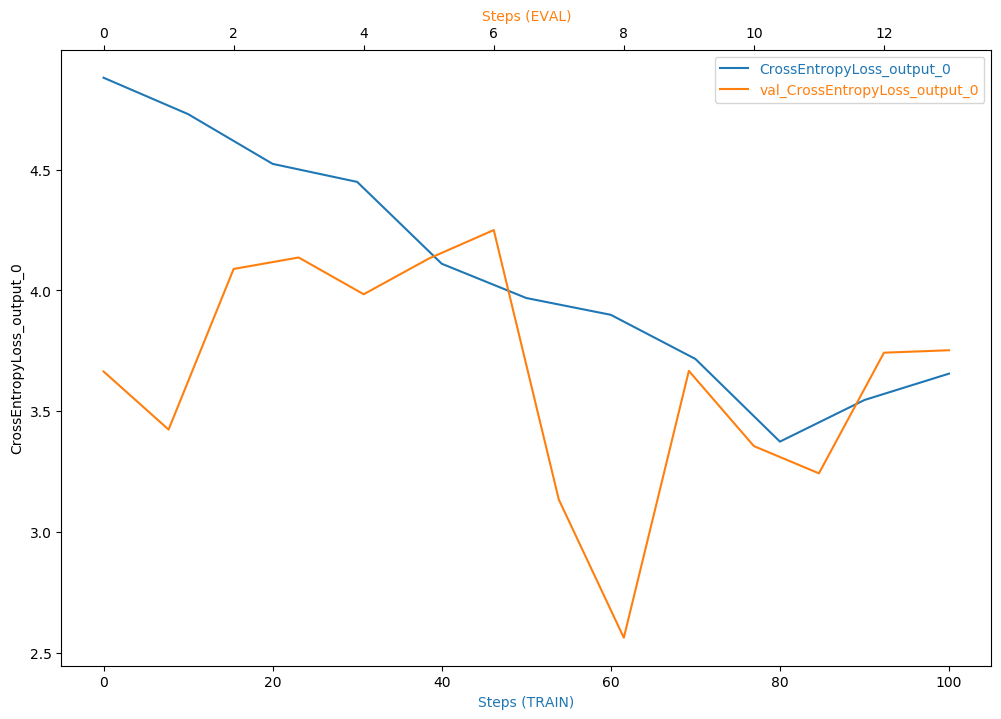

In [27]:
# plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [28]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-117886809722/pytorch-training-2022-11-15-23-26-17-396/rule-output


In [29]:
! aws s3 ls {rule_output_path} --recursive

2022-11-15 23:36:58     381815 pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-11-15 23:36:58     230996 pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-11-15 23:36:53        191 pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-11-15 23:36:53      23519 pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-11-15 23:36:53        126 pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-11-15 23:36:53        129 pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-11-15 23:36:53       5858 pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-re

In [30]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-117886809722/pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-117886809722/pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-117886809722/pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-117886809722/pytorch-training-2022-11-15-23-26-17-396/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-117886809722/pytorch-training-2022-11-15-23-26-17-3

In [31]:
import os
import IPython

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [32]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_report", "zip", "ProfilerReport")

'/root/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_report.zip'

## Model Deploying

In [33]:
# TODO: Deploy your model to an endpoint

predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") # TODO: Add your deployment configuration like instance type and number of instances

-----!

In [51]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

# s3 location of our saved model that was trained by the training job that used the best hyperparameters
model_data_artifacts = "s3://sagemaker-us-east-1-117886809722/pytorch-training-2022-11-15-23-26-17-396/output/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

# If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.m5.large")

------!

In [52]:
endpoint_name = predictor.endpoint_name
print(endpoint_name)

pytorch-inference-2022-11-16-01-23-52-363


In [54]:
# Using the runtime boto3 client to test the deployed models endpoint
import os
import io
import boto3
import json
import base64
import PIL
import numpy as np
from IPython.display import Image


# using the AWS's lightweight runtime solution to invoke an endpoint.
runtime= boto3.client('runtime.sagemaker')

test_images = ["./dogImages/test/021.Belgian_sheepdog/Belgian_sheepdog_01488.jpg",
               "./dogImages/test/020.Belgian_malinois/Belgian_malinois_01452.jpg",
               "./dogImages/test/091.Japanese_chin/Japanese_chin_06184.jpg",
               "./dogImages/test/007.American_foxhound/American_foxhound_00519.jpg",
               "./dogImages/test/110.Norwegian_lundehund/Norwegian_lundehund_07218.jpg"
              ]

test_images_expected_output = [21, 20, 91, 7, 110]

for index in range(len(test_images) ):
    test_image = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_image)
    print(test_file_path)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        
        print("Below is the test image:")
        Image(filename=test_image)
        
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = runtime.invoke_endpoint(EndpointName=endpoint_name,
                                       ContentType='image/jpeg',
                                       Body=payload)
        
        response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))
        
        print(f"Response i.e list of probabilities of breed categories: {response_body}")
        
        #finding the highest probability i.e stating the prediction
        dog_breed_prediction = np.argmax(response_body,1) + 1 #adding 1 to align indexes
        print(f"Inference for the above test image is : {dog_breed_prediction}")

Test image no: 1
./dogImages/test/021.Belgian_sheepdog/Belgian_sheepdog_01488.jpg
Below is the test image:
Expected dog breed category no : 21
Response i.e list of probabilities of breed categories: [[0.27866369 0.         0.         0.12892453 0.         0.83362055
  0.         0.         0.         1.17530954 0.         1.14818811
  0.68915939 0.         0.         0.         0.         0.80708373
  0.         2.14643097 0.         3.06473207 0.52293116 0.
  0.39243606 0.         0.         0.         3.29668617 0.
  1.00677454 0.         1.3626138  0.         0.         0.51392066
  0.         0.         0.         0.         0.         1.86991823
  0.         0.49785417 0.         0.         0.         0.
  0.         0.         0.         0.         0.         2.09712362
  0.         0.30752137 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         3.19794345 0.         0.         1.9994694  0.
  0.         1.26829672 0.       

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()